<a href="https://colab.research.google.com/github/ariaberlian/rbm_sr/blob/main/rbm_sr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !nvidia-smi | grep 'python' | awk '{ print $5 }' | xargs -n1 kill -9
# !nvidia-smi

In [2]:
# Python v3.6.12

##### Run This to Install #####

# ! pip install requirements.txt

## !git clone https://github.com/albertbup/deep-belief-network.git
## !pip install -r "deep-belief-network/requirements.txt"
## !mv "deep-belief-network" "deep_belief_network"

## """
## - add this to dbn/tensorflow/models.py:
##     import tensorflow._api.v2.compat.v1 as tf
##     tf.disable_v2_behavior()
## """

In [3]:
# from deep_belief_network.dbn.tensorflow.models import UnsupervisedDBN # use "from dbn.tensorflow import SupervisedDBNClassification" for computations on TensorFlow
from deep_belief_network.dbn.tensorflow.models import SupervisedDBNRegression
from utils.data_processing import DataProcessing
from utils.image_file_util import *
from utils.scoring import *
from utils.visualizer import *
import pandas as pd
from tqdm import tqdm
import gc
import multiprocessing
import time
import os

c:\Users\Aria Berlian\.conda\envs\rbm_sr\lib\site-packages\tensorflow\python\framework\dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\Aria Berlian\.conda\envs\rbm_sr\lib\site-packages\tensorflow\python\framework\dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\Aria Berlian\.conda\envs\rbm_sr\lib\site-packages\tensorflow\python\framework\dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\Aria Berlian\.conda\envs\rbm_sr\lib\site-packages

## DBN

In [4]:
def test(i, row, model_name, model, interpolation_factor, patch_size, stride,data_train_size, dp: DataProcessing):

    test_var = row[f"test{i}"]
    test_ref_var = row[f"test{i}_ref"]
    test_image = load_image(f"test/{test_var}")
    test_reference_image = load_image(f"test/{test_ref_var}")
    model = model.load(f"model/{model_name}.h5")
    
    print(f"Testing model: {model_name}...")
    print(f"Test Image: {test_var}")
    print(f"Reference Image: {test_ref_var}")
    interpolated_test = dp.interpolate(test_image, interpolation_factor)

    test_patches = dp.get_patches(interpolated_test, patch_size, stride)
    norm, int_test_dct_ex = dp.normalize_for_rbm(test_patches[:test_patches.shape[0]])
    if data_train_size < test_patches.shape[0]:
        norm = dp.normalize_for_rbm(test_patches[:data_train_size])

    test_patches_flat = dp.preprocess_for_rbm(norm)
    norm=None

    result_flat = model.predict(test_patches_flat)
    result_flat = dp.proccess_output(test_patches_flat, result_flat)

    result_patches, recons_dct_ex = dp.inverse_preprocess(
        result_flat, (patch_size[0], patch_size[1], 3)
    )

    reconstruct_image = dp.reconstruct_from_patches(
        result_patches, original_shape=test_reference_image.shape, patch_size=patch_size, stride=stride)
    

    visualize4image(test_image, "Test Image", interpolated_test, "Interpolated Test Image",
                     reconstruct_image, "Reconstructed Image", test_reference_image, "Reference Image")
    
    visualize4Histogram(test_image, "Test Image", interpolated_test, "Interpolated Test Image",
                     reconstruct_image, "Reconstructed Image", test_reference_image, "Reference Image")
    
    visualize_dct(int_test_dct_ex, "Interpolated Test")
    visualize_dct(recons_dct_ex, "Reconstructed Image")

    save_image_as("mandrill_hasil.png", reconstruct_image)

    norm, refs_dct_ex = dp.normalize_for_rbm(dp.get_patches(test_reference_image,patch_size,stride))
    visualize_dct(refs_dct_ex, "Reference Image")

    refs_flat = dp.preprocess_for_rbm(norm)

    psnr_baseline = calculate_psnr(test_reference_image, interpolated_test)
    ssim_baseline = calculate_ssim(test_reference_image, interpolated_test)*100
    rmse_baseline = calculate_rmse(refs_flat, test_patches_flat)
    psnr = calculate_psnr(test_reference_image, reconstruct_image)
    ssim = calculate_ssim(test_reference_image, reconstruct_image)*100
    rmse = calculate_rmse(refs_flat,result_flat)

    print(f"PSNR {i} Interpolated: {psnr_baseline:,.3f} dB")
    print(f"SSIM {i} Interpolated: {ssim_baseline:,.3f} %")
    print(f"RMSE {i} Interpolated: {rmse_baseline}")
    print(f"PSNR {i}: {psnr:,.3f} dB")
    print(f"SSIM {i}: {ssim:,.3f} %")
    print(f"RMSE {i}: {rmse}")
    
    # Cleanup: explicitly delete all variables
    del test_image, test_reference_image, interpolated_test, test_patches, test_patches_flat
    del result_flat, result_patches, reconstruct_image, refs_flat, norm
    gc.collect()

    return psnr_baseline,ssim_baseline,psnr,ssim,rmse



In [5]:
# Load file Excel
excel_name = "Experimentation.xlsx"
exp_df = pd.read_excel(excel_name, engine="openpyxl")


Training model: model_mandrill.tif_f(brickwall_256.png)_512_x2_p16_s4_l[512, 768, 768, 512]_sigmoid_lr0.01_lrft0.001


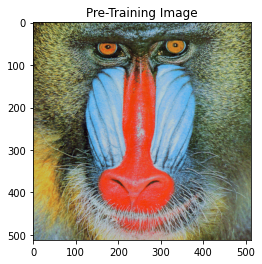

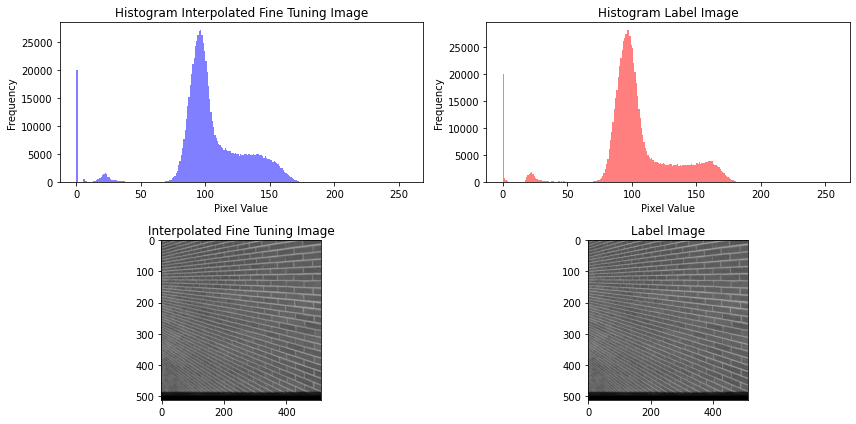

Model alrady exist!
Testing model: model_mandrill.tif_f(brickwall_256.png)_512_x2_p16_s4_l[512, 768, 768, 512]_sigmoid_lr0.01_lrft0.001...
Test Image: mandrill_256.png
Reference Image: mandrill.tif


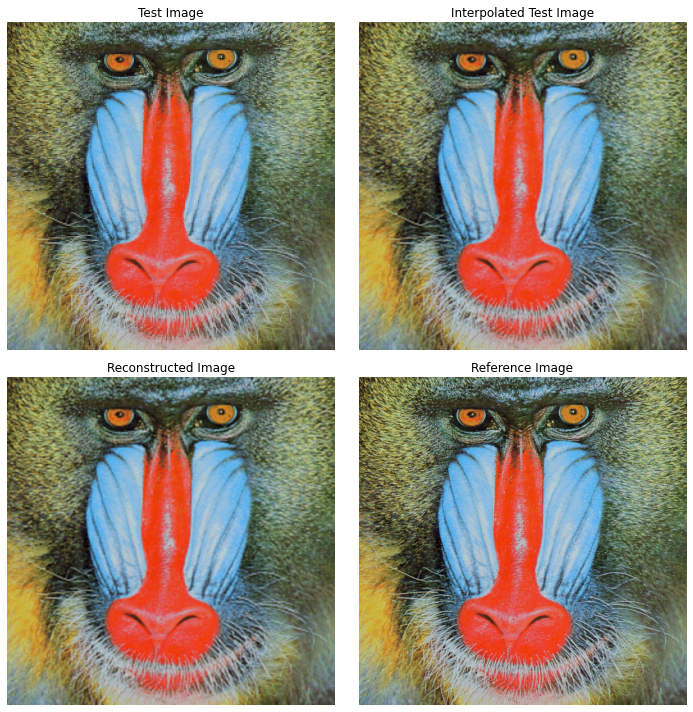

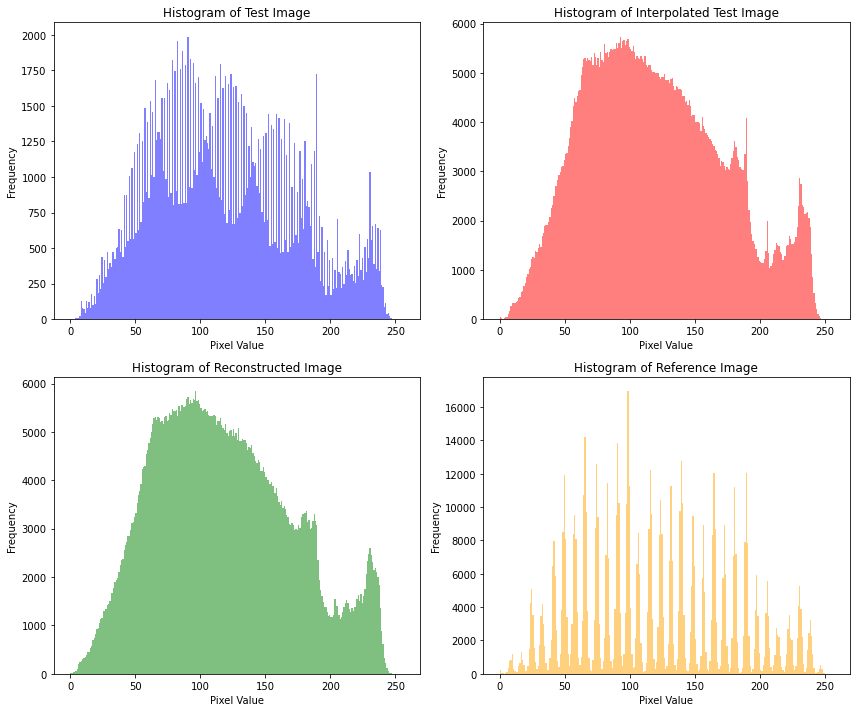

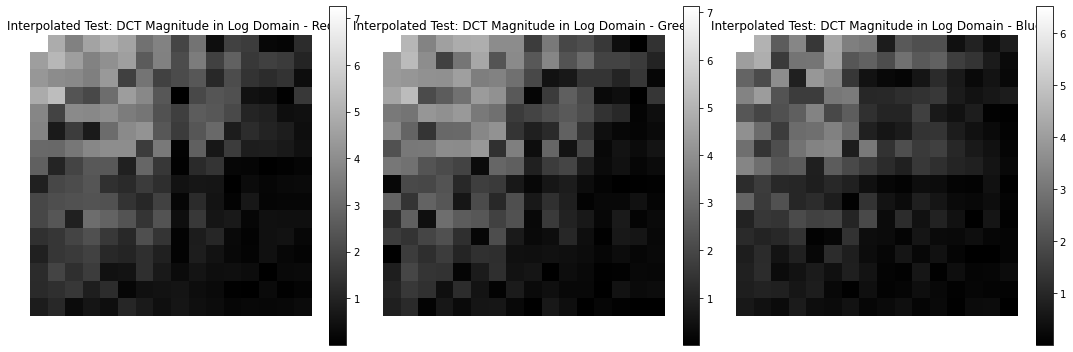

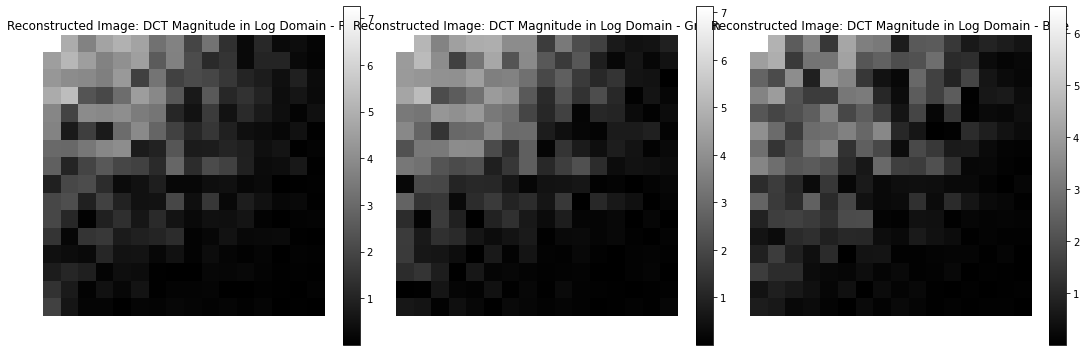

Image mandrill_hasil.png has been saved.


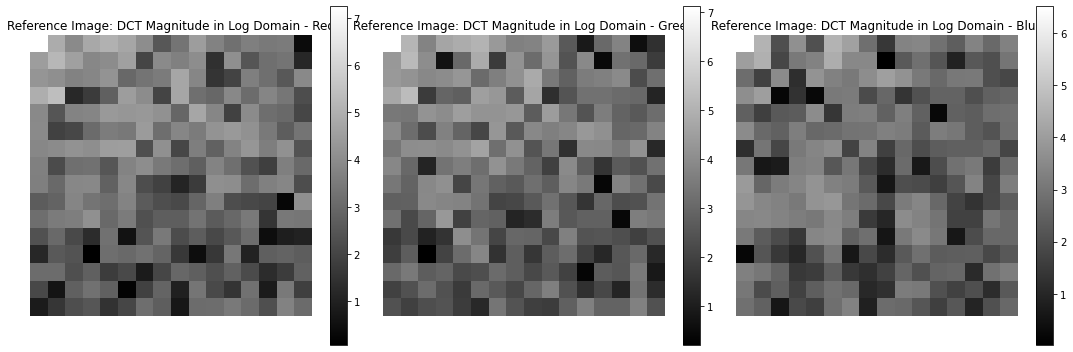

PSNR 1 Interpolated: 22.970 dB
SSIM 1 Interpolated: 71.408 %
RMSE 1 Interpolated: 0.10663213330921506
PSNR 1: 22.580 dB
SSIM 1: 68.286 %
RMSE 1: 0.08304773423813193
Finished processing row 66/66 with model model_mandrill.tif_f(brickwall_256.png)_512_x2_p16_s4_l[512, 768, 768, 512]_sigmoid_lr0.01_lrft0.001


In [6]:
def main(idx, row):
    try:
        # Baca parameter dari Excel untuk baris ini
        train = row["train"]
        fine_image = row["fine_tuning"]
        fine_label = row["label"]

        train_resolution = row['train_res']

        interpolation_factor = row['factor']
        patch_size = (row['patch_size'], row['patch_size'])
        stride = (row['stride'], row['stride'])
        data_train_size = row["data_train_size"]

        lr = row["lr"]
        lr_ft = row["lr_ft"]
        epoch = 500
        epoch_fine = 500
        layers = [int(layer) for layer in str(row['layers']).split(",")]
        batch_size = row['batch_size']
        activation_function = row["activation_function"]

        model_name = f"model_{train}_f({fine_image})_{train_resolution}_x{interpolation_factor}_p{patch_size[0]}_s{stride[0]}_l{layers}_{activation_function}_lr{lr}_lrft{lr_ft}"
        print(f"\nTraining model: {model_name}")

        # #### Model Configuration ####
        dbn = SupervisedDBNRegression(
                    hidden_layers_structure=layers,
                    batch_size=batch_size,
                    learning_rate_rbm=lr,
                    n_epochs_rbm=epoch,
                    activation_function=activation_function,
                    optimization_algorithm='sgd',
                    learning_rate=lr_ft,
                    n_iter_backprop=epoch_fine,
        )

        #### Load Data and Preprocess ####
        dp = DataProcessing()

        training_image = load_image(f"train/{train}")
        visualize_image(training_image, "Pre-Training Image")
        train_patches = dp.get_patches(training_image, patch_size=patch_size, stride=stride)
        norm, _ = dp.normalize_for_rbm(train_patches[:train_patches.shape[0]])
        if data_train_size < train_patches.shape[0]:
            norm = dp.normalize_for_rbm(train_patches[:data_train_size])

        X_pretrain = dp.preprocess_for_rbm(norm)

        del train_patches, training_image, norm
        gc.collect()

        fine_image = dp.interpolate(load_image(f'train/{fine_image}'), 2)
        label = load_image(f'train/{fine_label}')

        visualize_histogram_compare(fine_image, label, "Interpolated Fine Tuning Image", "Label Image")

        fine_patches = dp.get_patches(fine_image, patch_size=patch_size, stride=stride)
        norm, _ = dp.normalize_for_rbm(fine_patches[:fine_patches.shape[0]])
        if data_train_size < fine_patches.shape[0]:
            norm = dp.normalize_for_rbm(fine_patches[:data_train_size])
        X = dp.preprocess_for_rbm(norm)

        del fine_patches, fine_image, norm
        gc.collect()

        label_patches = dp.get_patches(label, patch_size=patch_size, stride=stride)
        norm, _ = dp.normalize_for_rbm(label_patches[:label_patches.shape[0]])
        if data_train_size < label_patches.shape[0]:
            norm = dp.normalize_for_rbm(label_patches[:data_train_size])
        y = dp.preprocess_for_rbm(norm)

        del label, label_patches, norm
        gc.collect()

        #### Train the Model ####
        if not(os.path.exists(f"model/{model_name}.h5")):
            print(f"Starting training for model: {model_name}")
            start_time = time.time()
            dbn.fit(X_pretrain,X,y)
            end_time = time.time()

            print("Training time: ", (end_time-start_time))
            dbn.save(f"model/{model_name}.h5")

            print(f"Model has been saved: {model_name}")
            exp_df.at[idx, "training_time"] = (end_time-start_time)

            del X_pretrain, X, y
            gc.collect()
        
        else:
            print("Model alrady exist!")

        #### Testing and Saving Results ####
        for i in range(1, 2):
            psnr_baseline, ssim_baseline, psnr, ssim,rmse = test(i, row, model_name, dbn, interpolation_factor, patch_size,stride,data_train_size, dp)
            # Save results to DataFrame
            exp_df.at[idx, f"b_psnr{i}"] = psnr_baseline
            exp_df.at[idx, f"b_ssim{i}"] = ssim_baseline
            exp_df.at[idx, f"psnr{i}"] = psnr
            exp_df.at[idx, f"ssim{i}"] = ssim
            exp_df.at[idx, f"rmse{i}"] = rmse
            exp_df.to_excel(excel_name, index=False)

        print(f"Finished processing row {idx+1}/{len(exp_df)} with model {model_name}")

    except Exception as e:
        print(f"Error processing row {idx+1}: {e}")
    
    finally:
        # Ensure all variables are deleted in the end
        del train, fine_label, train_resolution, interpolation_factor
        del patch_size, stride, data_train_size, lr, epoch, layers, batch_size, activation_function, model_name
        gc.collect()


specific_index = 65

# Process the specific row
if specific_index in exp_df.index:
    row = exp_df.loc[specific_index]
    main(specific_index, row) 
else:
    print(f"Index {specific_index} not found in the DataFrame.")


# for idx, row in tqdm(exp_df.iterrows(), total=len(exp_df), desc="Processing Rows"):
#     main(idx,row)


# print("All rows processed and results saved.")

In [7]:


# t_df = exp_df.iloc[51:58]

# exp_df['psnr_average'] = t_df[['psnr1', 'psnr2', 'psnr3', 'psnr4', 'psnr5']].mean(axis=1)
# exp_df['ssim_average'] = t_df[['ssim1', 'ssim2', 'ssim3', 'ssim4', 'ssim5']].mean(axis=1)
# exp_df['rmse_average'] = t_df[['rmse1', 'rmse2', 'rmse3', 'rmse4', 'rmse5']].mean(axis=1)

# print("Best PSNR: ", exp_df['psnr_average'].idxmax())
# print("Best SSIM: ", exp_df['ssim_average'].idxmax())
# print("Best RMSE: ", exp_df['rmse_average'].idxmin())

# print("Index 52 PSNR:", exp_df.iloc[52]['psnr_average'])
# print("Index 52 SSIM:", exp_df.iloc[52]['ssim_average'])
# print("Index 52 RMSE:", exp_df.iloc[52]['rmse_average'])
# print("Index 53 PSNR:", exp_df.iloc[53]['psnr_average'])
# print("Index 53 SSIM:", exp_df.iloc[53]['ssim_average'])
# print("Index 53 RMSE:", exp_df.iloc[53]['rmse_average'])

# exp_df.iloc[52]

### Best Training Image: Mandrill ###

In [8]:
# ft_df = exp_df.iloc[45:51]

# exp_df['psnr_average'] = ft_df[['psnr1', 'psnr2', 'psnr3', 'psnr4', 'psnr5']].mean(axis=1)
# exp_df['ssim_average'] = ft_df[['ssim1', 'ssim2', 'ssim3', 'ssim4', 'ssim5']].mean(axis=1)
# exp_df['rmse_average'] = ft_df[['rmse1', 'rmse2', 'rmse3', 'rmse4', 'rmse5']].mean(axis=1)

# print("Best PSNR: ", exp_df['psnr_average'].idxmax())
# print("Best SSIM: ", exp_df['ssim_average'].idxmax())
# print("Best RMSE: ", exp_df['rmse_average'].idxmin())

# print("Index 48 PSNR:", exp_df.iloc[48]['psnr_average'])
# print("Index 48 SSIM:", exp_df.iloc[48]['ssim_average'])
# print("Index 48 RMSE:", exp_df.iloc[48]['rmse_average'])
# print("Index 50 PSNR:", exp_df.iloc[50]['psnr_average'])
# print("Index 50 SSIM:", exp_df.iloc[50]['ssim_average'])
# print("Index 50 RMSE:", exp_df.iloc[50]['rmse_average'])

# print(exp_df.iloc[50])

# ### Best fine tuning: Brickwall ###

In [9]:
# lrft_df = exp_df.iloc[41:45]
# lrft_df["lr"]

# exp_df['psnr_average'] = lrft_df[['psnr1', 'psnr2', 'psnr3', 'psnr4', 'psnr5']].mean(axis=1)
# exp_df['ssim_average'] = lrft_df[['ssim1', 'ssim2', 'ssim3', 'ssim4', 'ssim5']].mean(axis=1)
# exp_df['rmse_average'] = lrft_df[['rmse1', 'rmse2', 'rmse3', 'rmse4', 'rmse5']].mean(axis=1)

# print("Best PSNR: ", exp_df['psnr_average'].idxmax())
# print("Best SSIM: ", exp_df['ssim_average'].idxmax())
# print("Best RMSE: ", exp_df['rmse_average'].idxmin())

# print("Index 41 PSNR:", exp_df.iloc[41]['psnr_average'])
# print("Index 41 SSIM:", exp_df.iloc[41]['ssim_average'])
# print("Index 41 RMSE:", exp_df.iloc[41]['rmse_average'])
# print("Index 42 PSNR:", exp_df.iloc[42]['psnr_average'])
# print("Index 42 SSIM:", exp_df.iloc[42]['ssim_average'])
# print("Index 42 RMSE:", exp_df.iloc[42]['rmse_average'])

# print(exp_df.iloc[42])

### Best Learning Rate Fine Tuning: 0.001 ###

In [10]:
# lr_df = exp_df.iloc[37:41]
# lr_df["lr"]

# exp_df['psnr_average'] = lr_df[['psnr1', 'psnr2', 'psnr3', 'psnr4', 'psnr5']].mean(axis=1)
# exp_df['ssim_average'] = lr_df[['ssim1', 'ssim2', 'ssim3', 'ssim4', 'ssim5']].mean(axis=1)
# exp_df['rmse_average'] = lr_df[['rmse1', 'rmse2', 'rmse3', 'rmse4', 'rmse5']].mean(axis=1)

# print("Best PSNR: ", exp_df['psnr_average'].idxmax())
# print("Best SSIM: ", exp_df['ssim_average'].idxmax())
# print("Best RMSE: ", exp_df['rmse_average'].idxmin())

# print(exp_df.iloc[38])
# ### BEST LEARNING RATE 0.01 ###

In [11]:
# a_df = exp_df.iloc[33:37]
# a_df["activation_function"]

# exp_df['psnr_average'] = a_df[['psnr1', 'psnr2', 'psnr3', 'psnr4', 'psnr5']].mean(axis=1)
# exp_df['ssim_average'] = a_df[['ssim1', 'ssim2', 'ssim3', 'ssim4', 'ssim5']].mean(axis=1)
# exp_df['rmse_average'] = a_df[['rmse1', 'rmse2', 'rmse3', 'rmse4', 'rmse5']].mean(axis=1)

# print("Best PSNR: ", exp_df['psnr_average'].idxmax())
# print("Best SSIM: ", exp_df['ssim_average'].idxmax())
# print("Best RMSE: ", exp_df['rmse_average'].idxmin())

# print(exp_df.iloc[26])

### Best Activation Function: SIGMOID ###

In [12]:
# ps_df = exp_df.iloc[23:33]
# exp_df['psnr_average'] = ps_df[['psnr1', 'psnr2', 'psnr3', 'psnr4', 'psnr5']].mean(axis=1)
# exp_df['ssim_average'] = ps_df[['ssim1', 'ssim2', 'ssim3', 'ssim4', 'ssim5']].mean(axis=1)
# exp_df['rmse_average'] = ps_df[['rmse1', 'rmse2', 'rmse3', 'rmse4', 'rmse5']].mean(axis=1)

# print("Best PSNR: ", exp_df['psnr_average'].idxmax())
# print("Best SSIM: ", exp_df['ssim_average'].idxmax())
# print("Best RMSE: ", exp_df['rmse_average'].idxmin())

# print(exp_df.iloc[26])

# ### BEST PATCH (16x16), STRIDE (4x4) ###

In [13]:
# print("PSNR:")
# best_psnr1_index = exp_df['psnr1'].idxmax()
# print(best_psnr1_index)
# best_psnr2_index = exp_df['psnr2'].idxmax()
# print(best_psnr2_index)
# best_psnr3_index = exp_df['psnr3'].idxmax()
# print(best_psnr3_index)
# best_psnr4_index = exp_df['psnr4'].idxmax()
# print(best_psnr4_index)
# best_psnr5_index = exp_df['psnr5'].idxmax()
# print(best_psnr5_index)

# print("SSIM:")
# best_ssim1_index = exp_df['ssim1'].idxmax()
# print(best_ssim1_index)
# best_ssim2_index = exp_df['ssim2'].idxmax()
# print(best_ssim2_index)
# best_ssim3_index = exp_df['ssim3'].idxmax()
# print(best_ssim3_index)
# best_ssim4_index = exp_df['ssim4'].idxmax()
# print(best_ssim4_index)
# best_ssim5_index = exp_df['ssim5'].idxmax()
# print(best_ssim5_index)

# print("RMSE:")
# best_rmse1_index = exp_df['rmse1'].idxmin()
# print(best_rmse1_index)
# best_rmse2_index = exp_df['rmse2'].idxmin()
# print(best_rmse2_index)
# best_rmse3_index = exp_df['rmse3'].idxmin()
# print(best_rmse3_index)
# best_rmse4_index = exp_df['rmse4'].idxmin()
# print(best_rmse4_index)
# best_rmse5_index = exp_df['rmse5'].idxmin()
# print(best_rmse5_index)


# exp_df['psnr_average'] = exp_df[['psnr1', 'psnr2', 'psnr3', 'psnr4', 'psnr5']].mean(axis=1)
# exp_df['ssim_average'] = exp_df[['ssim1', 'ssim2', 'ssim3', 'ssim4', 'ssim5']].mean(axis=1)
# exp_df['rmse_average'] = exp_df[['rmse1', 'rmse2', 'rmse3', 'rmse4', 'rmse5']].mean(axis=1)


# plt.figure(figsize=(10, 6))
# plt.plot(exp_df.index, exp_df['psnr_average'], marker='o', linestyle='-', color='b')
# plt.xlabel('Index')
# plt.ylabel('PSNR Average')
# plt.title('PSNR Average over Index')
# plt.grid(True)
# plt.show()

# plt.figure(figsize=(10, 6))
# plt.plot(exp_df.index, exp_df['ssim_average'], marker='o', linestyle='-', color='b')
# plt.xlabel('Index')
# plt.ylabel('SSIM Average')
# plt.title('SSIM Average over Index')
# plt.grid(True)
# plt.show()

# plt.figure(figsize=(10, 6))
# plt.plot(exp_df.index, exp_df['rmse_average'], marker='o', linestyle='-', color='b')
# plt.xlabel('Index')
# plt.ylabel('RMSE Average')
# plt.title('RMSE Average over Index')
# plt.grid(True)
# plt.show()

# print("Best PSNR Average", exp_df['psnr_average'].idxmax())
# print("Best SSIM Average", exp_df['ssim_average'].idxmax())
# print("Best RMSE Average", exp_df['rmse_average'].idxmin())


# exp_df['total_average'] = exp_df['psnr_average'] + exp_df['ssim_average'] - (exp_df['rmse_average'] * 100)

# print(exp_df['total_average'].idxmax())

# print("Index 4 PSNR:", exp_df.iloc[4]['psnr_average'])
# print("Index 4 SSIM:", exp_df.iloc[4]['ssim_average'])
# print("Index 4 RMSE:", exp_df.iloc[4]['rmse_average'])
# print("Index 12 PSNR:", exp_df.iloc[12]['psnr_average'])
# print("Index 12 SSIM:", exp_df.iloc[12]['ssim_average'])
# print("Index 12 RMSE:", exp_df.iloc[12]['rmse_average'])
# print("Index 15 PSNR:", exp_df.iloc[15]['psnr_average'])
# print("Index 15 SSIM:", exp_df.iloc[15]['ssim_average'])
# print("Index 15 RMSE:", exp_df.iloc[15]['rmse_average'])

### INDEX 15 SSIM paling tinggi, psnr rmse not bad ###
### Best Layers: 512,768,768,512 ###
# print(exp_df.iloc[15]["layers"])


In [14]:
# ## Training DBN
# def train(model, input : np.ndarray, model_name : str, repetitions: int, beta:float, interpolation_factor:float):
#     dp = DataProcessing()

#     visualize_histogram(input, title=f"Training Image")

#     curr_rep = 1
#     print("Repetisi saat ini: ", curr_rep)

#     model.fit(input)
#     model.save(f"model/{model_name}_{curr_rep}.h5")

#     while curr_rep < repetitions:
#         model = model.load(f"model/{model_name}_{curr_rep}.h5")
#         r = model.transform(input)
#         print("Shape Transformed: ", r.shape)
#         input = dp.proccess_output(u=input, r=r, beta=beta, s=interpolation_factor)
#         visualize_histogram(input, title=f"Training Image: After transform ({curr_rep})")
#         r = None

#         curr_rep += 1
#         print("Repetisi saat ini: ", curr_rep )

#         model.fit(input)
#         model.save(f"model/{model_name}_{curr_rep}.h5")

# ## Test DBN
# def test(test_image, test_reference_image, model, patch_size:tuple, stride:tuple, interpolation_factor:int):
#     dp = DataProcessing()

#     desired_shape = test_reference_image.shape
    
#     test_image = dp.interpolate(test_image, interpolation_factor=interpolation_factor)
    
#     visualize_image(test_image, title="Test Image after interpolation")
#     visualize_histogram(test_image, title="Test Image after interpolation", range=(0,256))
#     psnr_baseline_value = calculate_psnr(test_reference_image, test_image)
#     ssim_baseline_value = calculate_ssim(test_reference_image, test_image)*100

#     psnr_print = f"PSNR Baseline value: {psnr_baseline_value:,.3f} dB"
#     ssim_print = f"SSIM Baseline value: {ssim_baseline_value:,.3f}%"
#     print(psnr_print.replace(".", ","))
#     print(ssim_print.replace(".", ","))

#     test_patches = dp.get_patches(test_image,patch_size=patch_size, stride=stride)

#     # Process data for rbm
#     test_patches = dp.preprocess_for_rbm(test_patches)

#     # Infer test to model
#     result = model.transform(test_patches)

#     test_patches = dp.inverse_preprocess(
#         dp.proccess_output(test_patches, result, 1, interpolation_factor),
#         original_patch_shape=(patch_size[0], patch_size[1], 3)
#         )
    
#     result = None

#     # visualize_patches(test_patches, title="Test Patches Example", visualize_size=(6,6))

#     reconstruct_image = dp.reconstruct_from_patches(test_patches, original_shape=desired_shape, patch_size=patch_size, stride=stride)

#     test_patches = None

#     visualize_histogram_compare(original_image=test_reference_image, reconstruct_image=reconstruct_image)
#     psnr_value = calculate_psnr(test_reference_image, reconstruct_image)
#     ssim_value = calculate_ssim(test_reference_image, reconstruct_image)*100

#     psnr_print = f"PSNR value: {psnr_value:,.3f} dB"
#     ssim_print = f"SSIM value: {ssim_value:,.3f}%"

#     print(psnr_print.replace(".", ","))
#     print(ssim_print.replace(".", ","))


In [15]:
# tracemalloc.start()

# #### Patch size and Stride ####
# patch_size = (16,16)
# stride = (4,4)

# #### Load Data ####
# train_resolution = 512
# test_resolution = 256

# dp = DataProcessing()

# # Load Pre Training Data
# training_image = load_image("train/peppers.png")
# visualize_image(training_image, "Training Image")

# train_patches = dp.get_patches(training_image, patch_size=patch_size, stride=stride)

# # Feel free to reduce training set
# training_set_num = train_patches.shape[0]

# # visualize_patches(train_patches, "Train patches example")


# X_train = dp.preprocess_for_rbm(train_patches[:training_set_num])

# train_patches = None
# training_image = None

# # Load Fine Tuning Data
# fine_image = load_image("test/lenna_256.png")
# label_fine = load_image("train/lenna.png")
# fine_image = dp.interpolate(fine_image, 2)

# fine_patches = dp.get_patches(fine_image, patch_size, stride)
# label_patches = dp.get_patches(label_fine, patch_size, stride)

# fine_train = dp.preprocess_for_rbm(fine_patches)
# label_train = dp.preprocess_for_rbm(label_patches)



# #### Training parameter ###
# interpolation_factor = 2
# beta = 1
# Repetitions = 1
# lr = 0.01
# epoch = 100

# layers = [400,200,768]
# batch_size = 1024
# activation_function = 'relu'

# model_name = f"model_peppers_{train_resolution}_x{interpolation_factor}_p{patch_size[0]}_s{stride[0]}_({layers[0]}_{layers[1]}_{layers[2]})"

# # Models we will use
# # dbn = UnsupervisedDBN(hidden_layers_structure=layers,
# #                       batch_size=batch_size,
# #                       learning_rate_rbm=lr,
# #                       n_epochs_rbm=epoch,
# #                       activation_function=activation_function,
# #                       optimization_algorithm='sgd',)

# dbn = SupervisedDBNRegression(
#                     hidden_layers_structure=layers,
#                       batch_size=batch_size,
#                       learning_rate_rbm=lr,
#                       n_epochs_rbm=epoch,
#                       activation_function=activation_function,
#                       optimization_algorithm='sgd',
#                                     learning_rate=lr,
#                                     n_iter_backprop=200,

# )

# dbn.fit(X_train, fine_train, label_train)
# dbn.save("model/hmmm.h5")
# #### Train and Test ####

# snapshot1 = tracemalloc.take_snapshot()

# # comment this to skip training
# # train(
# #     model=dbn, 
# #     input=X_train,
# #     model_name=model_name,
# #     beta=beta,
# #     interpolation_factor=interpolation_factor,
# #     repetitions=Repetitions, 
# # )

# snapshot2 = tracemalloc.take_snapshot()
# top_stats = snapshot2.compare_to(snapshot1, 'lineno')

# print("[ Top 10 differences in memory allocation ]")
# for stat in top_stats[:10]:
#     print(stat)

# # Load Testing Data
# print("== Test 1 ==")
# test_image = load_image(f"test/peppers_256.png")
# visualize_image(test_image, title="Test Image")

# test_reference_image = load_image(f"train/peppers.png")
# dbn = dbn.load(f"model/hmmm.h5")

# test(
#     test_image=test_image,
#     test_reference_image=test_reference_image,
#     model=dbn,
#     patch_size=patch_size,
#     stride=stride,
#     interpolation_factor=interpolation_factor
# )



# print("== Test 2 ==")
# test_image = load_image(f"test/lenna_256.png")
# visualize_image(test_image, title="Test Image")

# test_reference_image = load_image(f"train/lenna.png")
# dbn = dbn.load(f"model/{model_name}_{Repetitions}.h5")

# test(
#     test_image=test_image,
#     test_reference_image=test_reference_image,
#     model=dbn,
#     patch_size=patch_size,
#     stride=stride,
#     interpolation_factor=interpolation_factor
# )

# print("== Test 3 ==")
# test_image = load_image(f"test/{test_resolution}/ct_lung4_{test_resolution}.png")
# visualize_image(test_image, title="Test Image")

# test_reference_image = load_image(f"test/{train_resolution}/ct_lung4_{train_resolution}.png")
# dbn = dbn.load(f"model/{model_name}_{Repetitions}.h5")

# test(
#     test_image=test_image,
#     test_reference_image=test_reference_image,
#     model=dbn,
#     patch_size=patch_size,
#     stride=stride,
#     interpolation_factor=interpolation_factor
# )